## Load necessary libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


import time, copy


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from torch.utils.data.dataset import random_split


# setting random seeds for reproducibility of results
torch.manual_seed(0)
np.random.seed(0)

## Load dataset and transforme it into tensor


In [2]:
img_HW = 32                                                      # Here, for MNIST, we have used img_HW = 20
d = img_HW**2   

print(f'image Hight = image Width = {img_HW}')
print(f'img_HW**2 = dimension of the Hilbert space = d = {d} \n')


#================================================================================================


transform = transforms.Compose([
    transforms.Resize((img_HW, img_HW)),                          # resize image
    transforms.Grayscale(),                                       # to transform into black and white images
    transforms.ToTensor(),                                        # to transform an image into a tensor
    transforms.Normalize(mean=(0.5,), std=(0.5,))                 # to put all the values between -1 and 1
])


def load_dataset(name):
    print(name,'\n')
    if name == "FashionMNIST":
        dataset = datasets.FashionMNIST(root="/home/FashionMNIST", 
                                        download=True, transform=transform)
    elif name == "MNIST":
        dataset = datasets.MNIST(root="/home/MNIST", 
                                 download=True, transform=transform)
    elif name == "CelebA":
        dataset = datasets.CelebA(root="/home/CelebA", 
                                  download=True, transform=transform)
    return dataset 

#----------------------------------------------------------------------------------------


dataset = load_dataset("CelebA")


num_datapoints = len(dataset)
channels = dataset[0][0].shape[0]


print(f'number of data points = {num_datapoints}')
print(f'number of channels = {channels} \n')


image Hight = image Width = 32
img_HW**2 = dimension of the Hilbert space = d = 1024 

CelebA 

Files already downloaded and verified
number of data points = 162770
number of channels = 1 



## Take a fraction of the data for faster training

In [3]:

frac =  (50000-0.1) / num_datapoints                      # at the place of 50000, for MNIST, we have used 5000
dataset, _ = random_split(dataset, [frac, 1-frac])
print(f'number of data points = {len(dataset)}\n')


number of data points = 50000



In [ ]:

'''This function is for collecting all the images of a single digit from the MNIST dataset.'''

def subset(dataset, digit):
    subset = []
    for i in range(len(dataset)):
        x, y = dataset[i]
        if y in [digit]: 
            subset.append((x, torch.tensor(y, dtype=torch.float32)))
    return subset


dataset = subset(dataset, 0)                     # <---------- choose one digit
print(f'number of examples = {len(dataset)}')



### View a training example:

x of torch.Size([1, 32, 32]) :


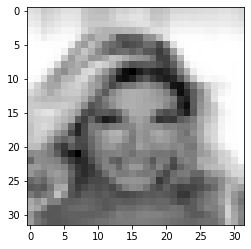

(x_min, x_max) = (-0.4823529124259949, 0.992)



In [4]:
idx = np.random.choice(len(dataset))

x = dataset[idx][0]
print(f'x of {x.shape} :')

plt.imshow(x.permute(1, 2, 0), cmap='gray')
plt.show()

print(f'(x_min, x_max) = {x.min().item(), round(x.max().item(),3)}\n')

# Define Interferometric Generative Adversarial Network (IGAN)


In the IGAN, the discriminator (D) and generator (G) are Interferometric Neural Networks (INNs).


__The discriminator (D)__, acting as a binary classifier, distinguishes between real data ${\textbf{x}}$ labeled as 1 and fake data ${G(\textbf{z})}$ labeled as 0. It assesses both real and generated data and provides a probability score for an input being real.



__The generator (G)__ takes random noise vectors $\textbf{z}$ and endeavors to produce outputs $G(\textbf{z})$ that closely resemble real data.


$ $

In [5]:

class parallel_interferometers(nn.Module):
    def __init__(self, dim_out, dim_in):
        super(parallel_interferometers, self).__init__()

        self.dim_out = dim_out                                            # output dimention
        self.dim_in = dim_in                                              # input dimention

        torch.manual_seed(1)                         # setting a specific seed for reproducibility of results
        phases = torch.randn((1, dim_out, dim_in), dtype=torch.float)     # Initialize learnable phases
        nn.init.xavier_uniform_(phases)
        self.phases = nn.Parameter(phases)


    def forward(self, x):                          # x.shape = (batch_size, 1 or dim_out, dim_in)
        x = x * torch.exp(1j * self.phases)        # Perform dim_out parallel the phase shifters
        x = torch.fft.fft(x, norm='ortho')         # Perform parallel 1D Fast Fourier Transforms (beamsplitters)
        return x                                   # x.shape = (batch_size, dim_out, dim_in)


__An interferometric block :__ $d_\text{out}$ parallel sequences of interferometers. Each sequence (represented by, $U(\Phi)$, square) has $L$ interferometers.

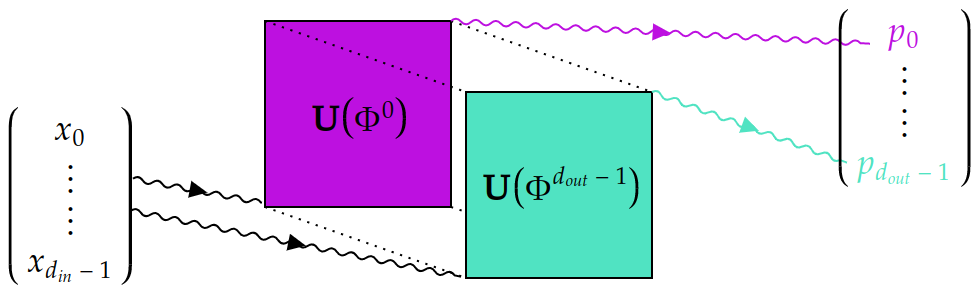

In [6]:

class interferometric_block(nn.Module):
    def __init__(self, dim_out, dim_in, L, channels=1):
        super(interferometric_block, self).__init__()

        self.dim_out = dim_out                                            # output dimention
        self.dim_in = dim_in                                              # input dimention
        self.L = L                                                        # number of quantum layers
        self.channels = channels

        self.phase_filters_layers = nn.ModuleList([parallel_interferometers(dim_out, dim_in) for _ in range(L)])


    def forward(self, x):
        x = x.view(-1, self.channels, self.dim_in)


        x = F.normalize(x, dim=-1)           # amplitude encodings  x -->  |x>

        #------------------------------------------------------------------------------------

        x = torch.fft.fft(x, norm='ortho')   # First ID Fast Fourier Transforms (beamsplitters)

        for phase_filters in self.phase_filters_layers:
            x = phase_filters(x)

         #------------------------------------------------------------------------------------

        x = x*(x.conj())                     # measurement in the computational basis and getting probabilities
        x = torch.real(x)                    # dropping the imaginary components 0j

        x = x[:,:,0]                         # probability of getting 0 outcome from each sequence

        return x



Here, __an Interferometric Neural Networks (INN)__ is made of $M=2$ blocks, where the dimensions $\textbf{d}ims=(d_0,d_1,d_2)$ and the quantum layers $\textbf{L}s = (L_0,L_1)$.

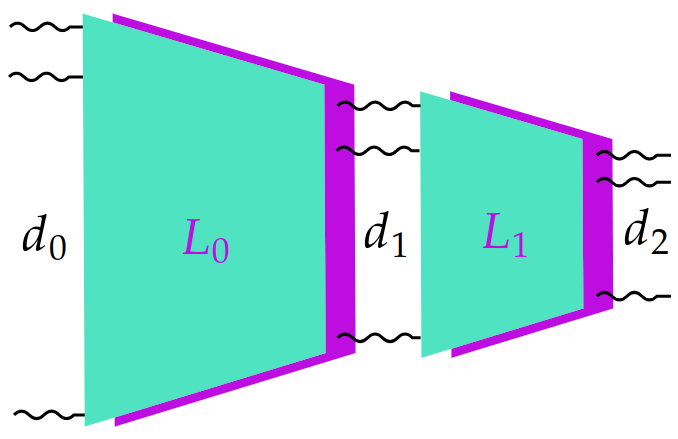

In [7]:

class INN(nn.Module):                               # Define QML model = Interferometric Neural Network (INN)
    def __init__(self, dims, Ls):
        super(INN, self).__init__()

        self.dims = dims                            # dimension of a feature vector before or after a block
        self.Ls = Ls                                # number of quantum layers in a block
        self.M = len(dims) - 1                      # number of blocks = M


        self.blocks = nn.ModuleList()               # Initialize an empty ModuleList

        for i in range(self.M-1):
            self.blocks.append(interferometric_block(dim_out=dims[i+1], dim_in=dims[i], L=Ls[i]))

        self.last_block = interferometric_block(dim_out=dims[-1], dim_in=dims[-2], L=Ls[-1])
        

    def forward(self, x):

        for block in self.blocks:
            x = block(x)

        x = self.last_block(x)

        return x

## Define device, hyperparameters, dataloader

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device = {device}')
torch.set_num_threads(1)                                             # it is for reproducibility of results

#===============================================================================================


dimD = [d, 2**7,  1]
LsD = [3,3]
dimG = [2**5, 2**7,  d]


# Here, for MNIST, we have used 
# dimD = [d, 2**6,  1]
# LsD = [3,3]
# dimG = [2**2, 2**6,  d]


z_dim = dimG[0]
LsG = LsD[::-1]


#=================================================================================================

M = len(dimD) - 1

print()
print(f'dimension of a feature vector before and after an interferometric block in Discriminator = {dimD}')
print(f'dimension of a feature vector before and after an interferometric block in Generator = {dimG}')
print(f'z_dim = {z_dim} = dimension of a latent vector z \n')

print(f'number of quantum layers in interferometric blocks in Discriminator = {LsD}')
print(f'number of quantum layers in interferometric blocks in Generator = {LsG}')
print(f'number of interferometric blocks = {M}\n')



#===============================================================================================
# optimizer Adam's hyperparameters

lr = 1e-2

b1 = 0.5
b2 = 0.9


#===============================================================================================

batch_size = 2**9                      # Here, for MNIST, we have used batch_size = 2**7 
num_epochs = 10

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f'number of batches = {len(dataloader)}, batch_size = {batch_size}\n')



device = cpu

dimension of a feature vector before and after an interferometric block in Discriminator = [1024, 128, 1]
dimension of a feature vector before and after an interferometric block in Generator = [32, 128, 1024]
z_dim = 32 = dimension of a latent vector z 

number of quantum layers in interferometric blocks in Discriminator = [3, 3]
number of quantum layers in interferometric blocks in Generator = [3, 3]
number of interferometric blocks = 2

number of batches = 98, batch_size = 512



## Training...

Here both the discriminator (D) and generator (G) are Interferometric Neural Networks (INNs). We sample noise
vectors $\textbf{z}$ from the standard normal distribution ${\mathcal{N}(0,1)}$.

In [9]:
%%time


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


dis = INN(dims=dimD, Ls=LsD).to(device)                                     # start Discriminator (D) instance
opt_dis = torch.optim.Adam(dis.parameters(), lr=lr, betas=(b1, b2))         # define Discriminator's optimizer


gen = INN(dims=dimG, Ls=LsG).to(device)                                     # start Generator (G) instance
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(b1, b2))         # define Generator's optimizer


loss_fn = nn.BCELoss()                                                      # loss functions for both D and G


#----------------------------------------------------------------------------------------
# to store the performance of generator at each step

fixed_noise = torch.randn((12, 1, z_dim), device=device)               # a sample of z vectors, that will be fixed
writer_fake = SummaryWriter(f"logs/fake")
step = 0


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Gen_Imgs = []
Loss_Prob = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)                                           # a batch of real images

        #===============================================================================================
        ### Train Discriminator: min - log(D(x)) - log(1 - D(G(z)))

        dis_real = dis(real).view(-1)                                    # a forward pass through discriminator D(x)
        lossD_real = loss_fn(dis_real, torch.ones_like(dis_real))        # = - log(D(x))

        noise = torch.randn((batch_size, 1, z_dim), device=device)       # a batch of z vectors
                                                                         # fake = G(z)
        fake = gen(noise)                                                # a forward pass through generator
        fake = 2*fake-1                                                  # now values in fake lie in [-1, 1]
        fake = torch.tanh(fake)
        dis_fake = dis(fake).view(-1)                                    # a forward pass through discriminator D(G(z))

        lossD_fake = loss_fn(dis_fake, torch.zeros_like(dis_fake))       # = - log(1 - D(G(z)))

        lossD = (lossD_real + lossD_fake) / 2                            # total loss for discriminator

        dis.zero_grad()                               # Clear gradients of discriminator
        lossD.backward(retain_graph=True)             # Derive gradients, backpropagation through discriminator
        opt_dis.step()                                # Update parameters of discriminator based on gradients

        #===============================================================================================
        ### Train Generator: min - log(D(G(z))
        
        dis_fake2 = dis(fake).view(-1)                             # it is like dis_fake but after the dis-update

        lossG = loss_fn(dis_fake2, torch.ones_like(dis_fake2))     # = - log(D(G(z)) = total loss for generator

        gen.zero_grad()                               # Clear gradients of generator
        lossG.backward()                              # Derive gradients, backpropagation through generator
        opt_gen.step()                                # Update parameters of generator based on gradients

        #===============================================================================================

        if batch_idx == 0:
            mean_prob_fake = torch.mean(dis_fake).detach().item()
            mean_prob_real = torch.mean(dis_real).detach().item()
            
            Loss_Prob.append([lossD.detach().item(), lossG.detach().item(), mean_prob_fake, mean_prob_real])

            print(f'Epoch: {epoch:2d}       Loss D: {lossD:.3f}      Loss G: {lossG:.3f}      mean(D(fake)) = {mean_prob_fake:.3f}      mean(D(real)) = {mean_prob_real:.2f} ')

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, channels, img_HW, img_HW)  # generate fake images from the fixed noise vectors z
                
                Gen_Imgs.append(fake)
                
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True, nrow=4)
                writer_fake.add_image("Generated Fake Images", img_grid_fake, global_step=step)
                step += 1


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


print(f'\n ~~~~~ training is done ~~~~~\n ')



Epoch:  0       Loss D: 2.438      Loss G: 4.838      mean(D(fake)) = 0.008      mean(D(real)) = 0.01 
Epoch:  1       Loss D: 0.171      Loss G: 3.528      mean(D(fake)) = 0.070      mean(D(real)) = 0.83 
Epoch:  2       Loss D: 0.258      Loss G: 2.313      mean(D(fake)) = 0.187      mean(D(real)) = 0.82 
Epoch:  3       Loss D: 0.418      Loss G: 1.639      mean(D(fake)) = 0.271      mean(D(real)) = 0.65 
Epoch:  4       Loss D: 0.510      Loss G: 1.299      mean(D(fake)) = 0.324      mean(D(real)) = 0.57 
Epoch:  5       Loss D: 0.554      Loss G: 1.141      mean(D(fake)) = 0.372      mean(D(real)) = 0.54 
Epoch:  6       Loss D: 0.602      Loss G: 0.981      mean(D(fake)) = 0.420      mean(D(real)) = 0.53 
Epoch:  7       Loss D: 0.628      Loss G: 0.871      mean(D(fake)) = 0.458      mean(D(real)) = 0.53 
Epoch:  8       Loss D: 0.624      Loss G: 0.875      mean(D(fake)) = 0.462      mean(D(real)) = 0.54 
Epoch:  9       Loss D: 0.629      Loss G: 0.889      mean(D(fake)) = 0.4

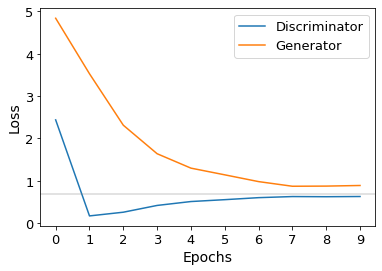

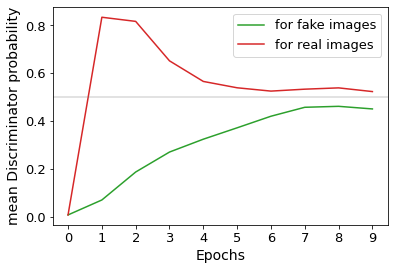

number of parameters of (Discriminator and Generator) = (393600, 405504)


In [10]:
Loss_Prob = np.array(Loss_Prob)

#np.save('Loss_Prob.npy', Loss_Prob)
#Loss_Prob = np.load('Loss_Prob.npy')


plt.plot(Loss_Prob[:,0], label='Discriminator')
plt.plot(Loss_Prob[:,1], label='Generator')
plt.axhline(y = np.log(2), color = 'gray', alpha=0.3) 
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(range(num_epochs), fontsize=13)
plt.legend(fontsize=13)
plt.show()

plt.plot(Loss_Prob[:,2], label='for fake images', c='C2')
plt.plot(Loss_Prob[:,3], label='for real images', c='C3')
plt.axhline(y = 0.5, color = 'gray', alpha=0.3) 
plt.ylabel('mean Discriminator probability', fontsize=14)     
plt.xlabel('Epochs',fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(range(num_epochs),fontsize=13)
plt.legend(fontsize=13)
plt.show()

#----------------------------------------------------------------------------------------

num_Dparams = sum(p.numel() for p in dis.parameters() if p.requires_grad)
num_Gparams = sum(p.numel() for p in gen.parameters() if p.requires_grad)

print(f'number of parameters of (Discriminator and Generator) = {num_Dparams, num_Gparams}')


$ $

## Load the TensorBoard extension to see how image generated by the interferometric generator improves with its training

In [11]:
%load_ext tensorboard
%tensorboard --logdir=logs

## Save trained model : Interferometric Discriminator and Generator

In [12]:
dis_state_dict = dis.state_dict()                             # for saving or loading the trained generator
gen_state_dict = gen.state_dict()

#torch.save(dis_state_dict, "IDis.pth")
#torch.save(gen_state_dict, "IGen.pth")

## Load trained model : Interferometric Generator

In [13]:

gen = INN(dims=dimG, Ls=LsG).to(device)                       # start Generator (G) instance
gen.load_state_dict(gen_state_dict)

#gen.load_state_dict(torch.load("IGen.pth"))

<All keys matched successfully>

## Generate fake images from the trained Interferometric Generator

(x_min, x_max) = (-0.6629742383956909, 0.519)


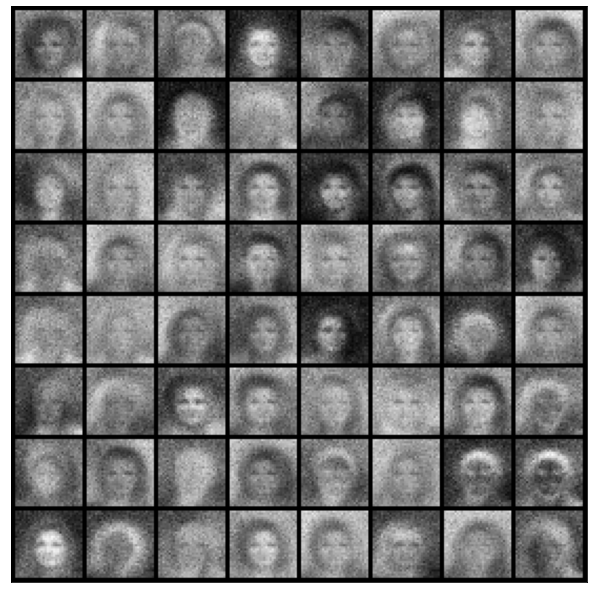

In [14]:

new_noise = torch.randn((8*8, 1, z_dim), device=device)             # sample noise vectors z
generated_fake_images = gen(new_noise).detach().reshape(-1, channels, img_HW, img_HW)      # G(z)
generated_fake_images = 2*generated_fake_images - 1                 # now values in fake lie in [-1, 1]
generated_fake_images = torch.tanh(1*generated_fake_images)
print(f'(x_min, x_max) = {generated_fake_images.min().item(), round(generated_fake_images.max().item(),3)}')

#===========================================================================================

Img_grid_fake = torchvision.utils.make_grid(generated_fake_images, normalize=True, nrow=8)



fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1])
plt.imshow(Img_grid_fake.to('cpu').permute(1, 2, 0))
ax.set_xticks([])
ax.set_yticks([])
plt.show()


$ $

### View a sample of training images

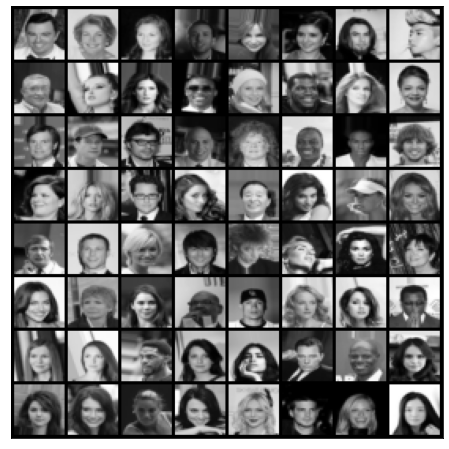

In [15]:
idx = np.random.choice(len(dataset), 64, replace=False)
img = torch.tensor(np.array([dataset[i][0].numpy() for i in idx]))
img_grid = torchvision.utils.make_grid(img, normalize=True, nrow=8)

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1])
plt.imshow(img_grid.to('cpu').permute(1, 2, 0))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

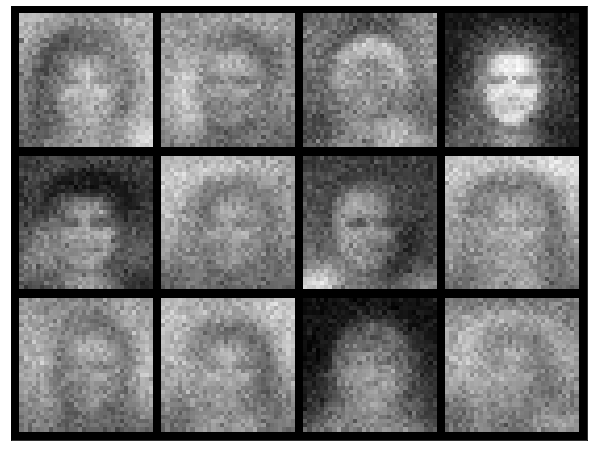

In [16]:
'''to see how the image generated by the interferometric generator improves with the training steps'''

Step = -1

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1])
gen_image = 2*Gen_Imgs[Step] - 1                             # now values in fake lie in [-1, 1]
gen_image = torch.tanh(1*gen_image)
img_grid = torchvision.utils.make_grid(gen_image, normalize=True, nrow=4)
ax.imshow(img_grid.to('cpu').permute(1, 2, 0))
ax.set_xticks([])
ax.set_yticks([])
plt.show()


$ $

$ $